# 3D Gene Expression Pattern

This notebook demonstrates the 3D Gene Expression Pattern. This is done in the following three steps.
1. 3D Gene Expression Pattern in original point cloud model;
2. Interpolated 3D Gene Expression Pattern in volume models based on the interpolation kernel;
3. Interpolated 3D Gene Expression Pattern in volume models based on deep learning.

### Packages

In [1]:
import os
import anndata as ad
import numpy as np
import spateo as st

/home/yao/PythonProject/Yao_packages/spateo-notebooks/three_dims_reconstruction/spateo/configuration.py:371: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)
/home/yao/PythonProject/Yao_packages/spateo-notebooks/three_dims_reconstruction/spateo/configuration.py:372: UserWarning: Trying to register the cmap 'darkblue' which already exists.
  plt.register_cmap("darkblue", darkblue_cmap)
/home/yao/PythonProject/Yao_packages/spateo-notebooks/three_dims_reconstruction/spateo/configuration.py:373: UserWarning: Trying to register the cmap 'darkgreen' which already exists.
  plt.register_cmap("darkgreen", darkgreen_cmap)
/home/yao/PythonProject/Yao_packages/spateo-notebooks/three_dims_reconstruction/spateo/configuration.py:374: UserWarning: Trying to register the cmap 'darkred' which already exists.
  plt.register_cmap("darkred", darkred_cmap)
/home/yao/PythonProject/Yao_packages/spateo-notebooks/three_dims_reconstruction/spateo/confi

### Data source

In [2]:
adata = ad.read_h5ad("/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/5_annotation/E8-10_b_all_anno_scsq.h5ad")

data_folder="/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction/E8-10_b_all_anno_scsq/1_reconstruct_whole_body/mesh"
wb_pc = st.tl.tdr.read_model(filename=os.path.join(data_folder, "pc_model.vtk"))
wb_voxel = st.tl.tdr.read_model(filename=os.path.join(data_folder, "voxel_model.vtk"))
########################################################################################################################
save_folder = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_cellbin_tdr_folder = os.path.join(save_folder, r"E8-10_b_all_anno_scsq")
save_cellbin_tdr_5_folder = os.path.join(save_cellbin_tdr_folder, r"5_gene_expression_pattern_in_3D")
save_cellbin_tdr_mesh_folder = os.path.join(save_cellbin_tdr_5_folder, r"mesh")
save_cellbin_tdr_image_folder = os.path.join(save_cellbin_tdr_5_folder, r"image")

for folder in [save_folder, save_cellbin_tdr_folder, save_cellbin_tdr_5_folder, save_cellbin_tdr_mesh_folder, save_cellbin_tdr_image_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

### 3D Gene Expression Pattern in original point cloud model

#### Add original gene expression info to the point cloud model

In [3]:
marker_genes = ["Obp99a", "CG12011", "nur", "PPO1"]

for mkg in marker_genes:
    obs_index = wb_pc.point_data["obs_index"].tolist()
    mkg_exp = adata[obs_index, mkg].X.flatten().astype(np.float64)

    mkg_exp_adj = mkg_exp.copy()
    mkg_exp_adj[mkg_exp_adj <= 0] = 0

    mkg_amap = mkg_exp.copy()
    mkg_amap = mkg_amap - mkg_amap.min()
    mkg_amap = mkg_amap / mkg_amap.max()
    mkg_amap[mkg_amap <= 0.1] = 0.1

    st.tl.tdr.add_model_labels(model=wb_pc, labels=mkg_exp_adj, key_added=mkg, where="point_data", colormap="Purples", alphamap=mkg_amap, inplace=True)


#### Visualization

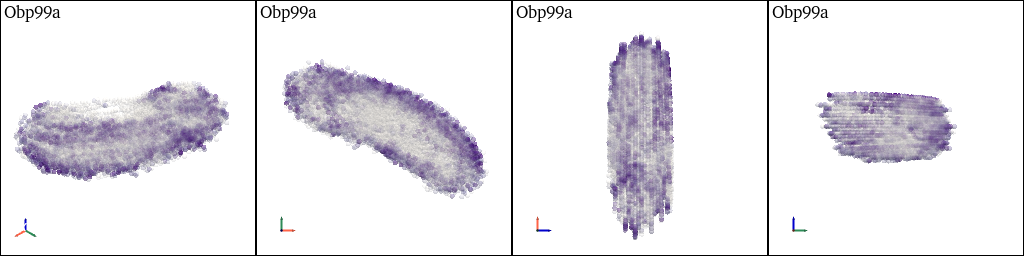

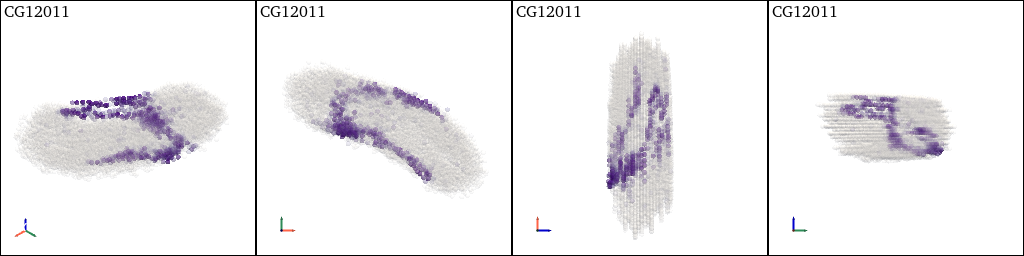

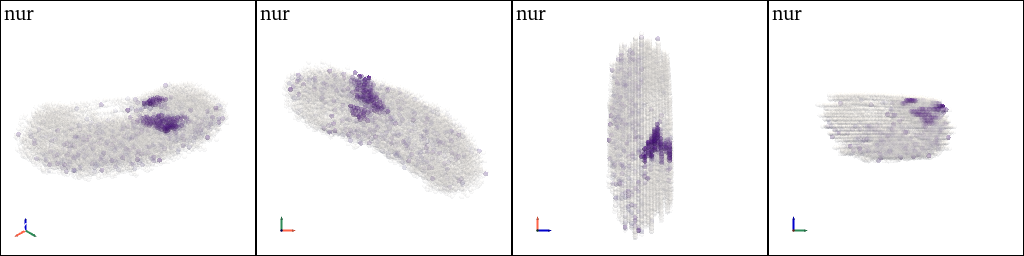

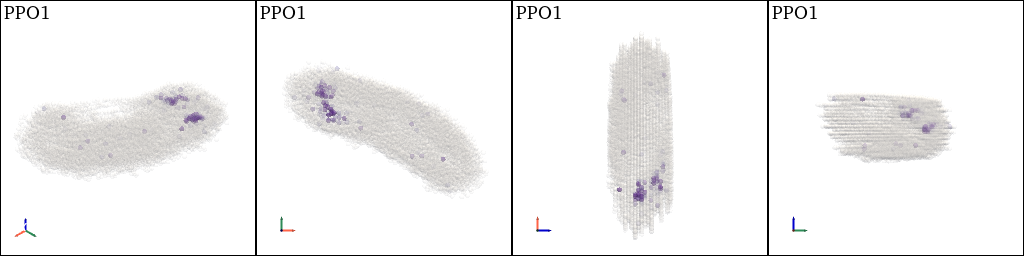

In [4]:
def visualization(model, gene_name, jupyter=False, save_image=None):
    p = st.pl.create_plotter(jupyter=jupyter, off_screen=True, background="white", shape=(1, 4), window_size=(1024, 256))
    for i, cpo in enumerate(["iso", "xy", "zx", "yz"]):
        p.subplot(0, i)
        st.pl.add_model(plotter=p, model=model, key=gene_name)
        p.add_axes()
        p.add_text(gene_name, color="black", font_size=8, font="times")
        p.camera_position = cpo
    st.pl.output_plotter(p=p, filename=save_image, jupyter=jupyter)

for marker_gene in marker_genes:
    visualization(wb_pc, gene_name=marker_gene, jupyter=True, save_image=None)
    visualization(wb_pc, gene_name=marker_gene, jupyter=False, save_image=os.path.join(save_cellbin_tdr_image_folder, f"{marker_gene}_pc.tiff"))

### Interpolated 3D Gene Expression Pattern in volume models based on the interpolation kernel

#### Use shepard kernel

vtkShepardKernel is an interpolation kernel that uses the method of Shepard to perform interpolation. The weights are computed as 1/r^p, where r is the distance to
a neighbor point within the kernel radius R; and p (the power parameter) is a positive exponent (typically p=2).

In [5]:
source_pc = wb_pc.copy()
del source_pc.point_data["obs_index"], source_pc.point_data["groups"]
interpolate_voxel = st.tl.tdr.interpolate_model(model=wb_voxel, source=source_pc, N=5, where="point_data", kernel="shepard")

#### Visualization

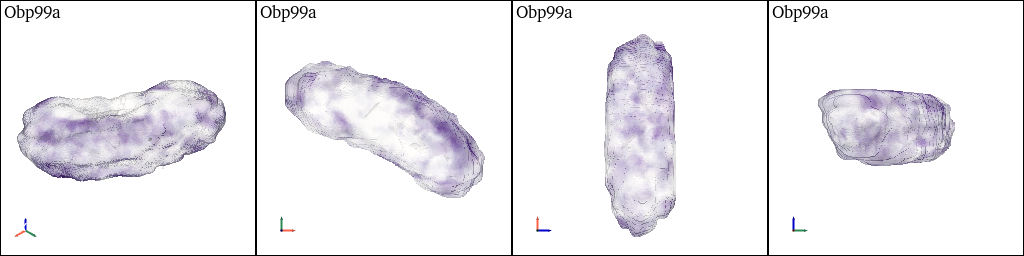

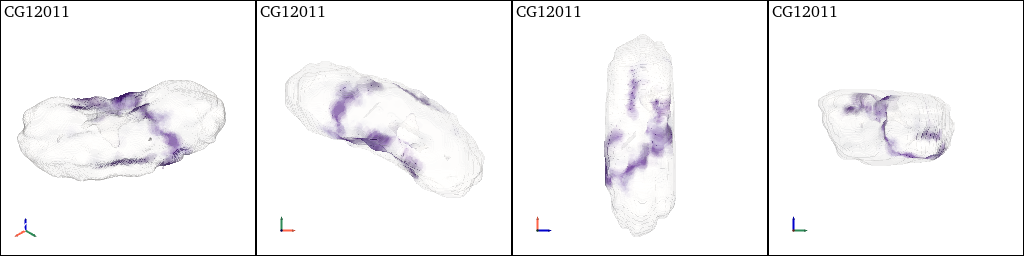

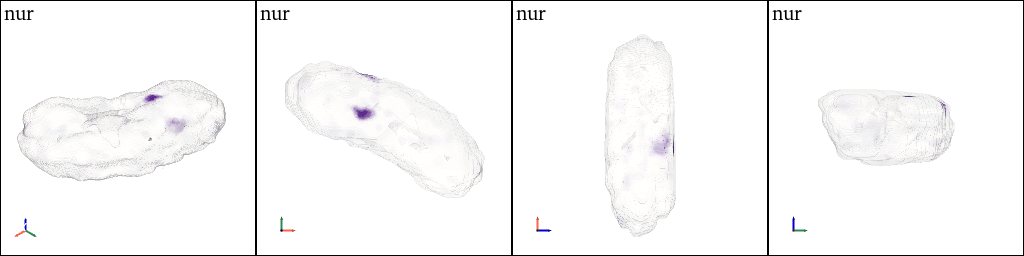

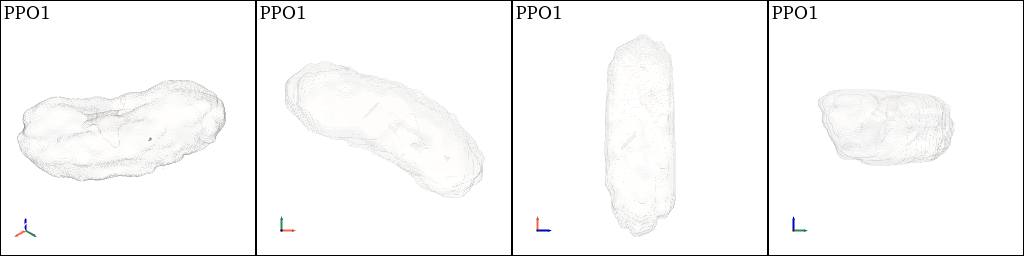

In [6]:
for marker_gene in marker_genes:
    visualization(interpolate_voxel, gene_name=marker_gene, jupyter=True, save_image=None)
    visualization(interpolate_voxel, gene_name=marker_gene, jupyter=False,
                  save_image=os.path.join(save_cellbin_tdr_image_folder, f"{marker_gene}_shepard_kernel.tiff"))

#### Slicing the model

In [7]:
slices_model = st.tl.tdr.three_d_slice(model=interpolate_voxel, axis="x", n_slices=10, method="axis")
print(slices_model[0].point_data)

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : PPO1_rgba
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    groups_rgba             float64  (439, 4)
    SelectedPoints          float32  (439,)
    Obp99a                  float64  (439,)
    Obp99a_rgba             float64  (439, 4)
    CG12011                 float64  (439,)
    CG12011_rgba            float64  (439, 4)
    nur                     float64  (439,)
    nur_rgba                float64  (439, 4)
    PPO1                    float64  (439,)
    PPO1_rgba               float64  (439, 4)             SCALARS
    orig_extract_id         float32  (439,)


#### Visualization

Obp99a


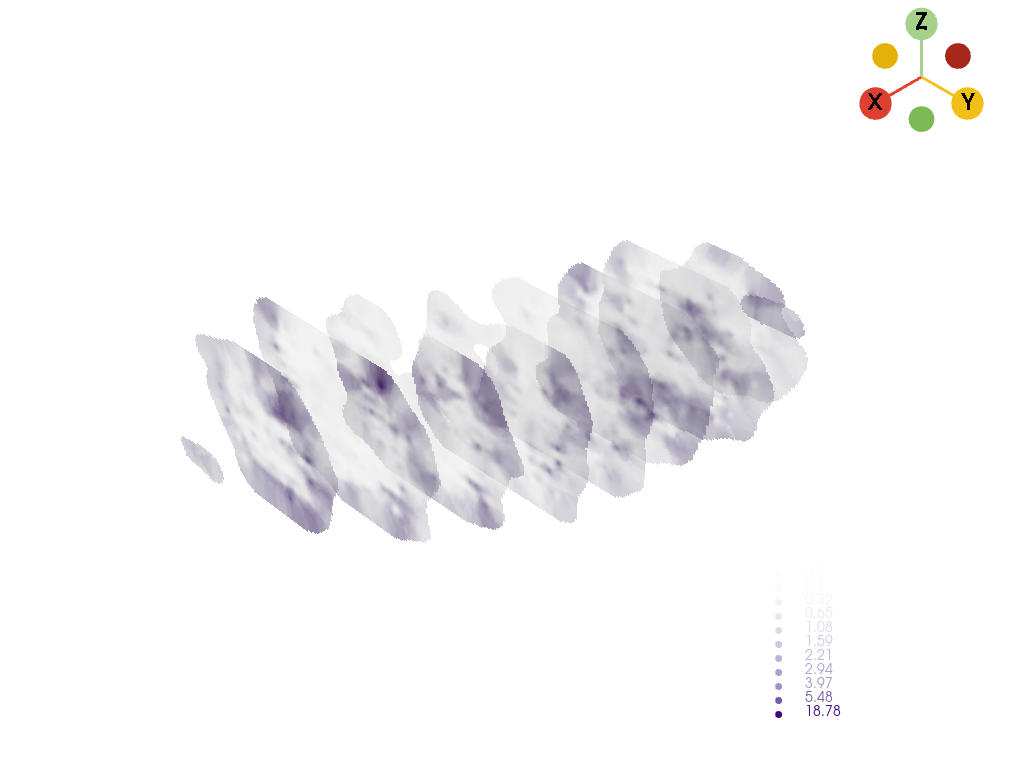

CG12011


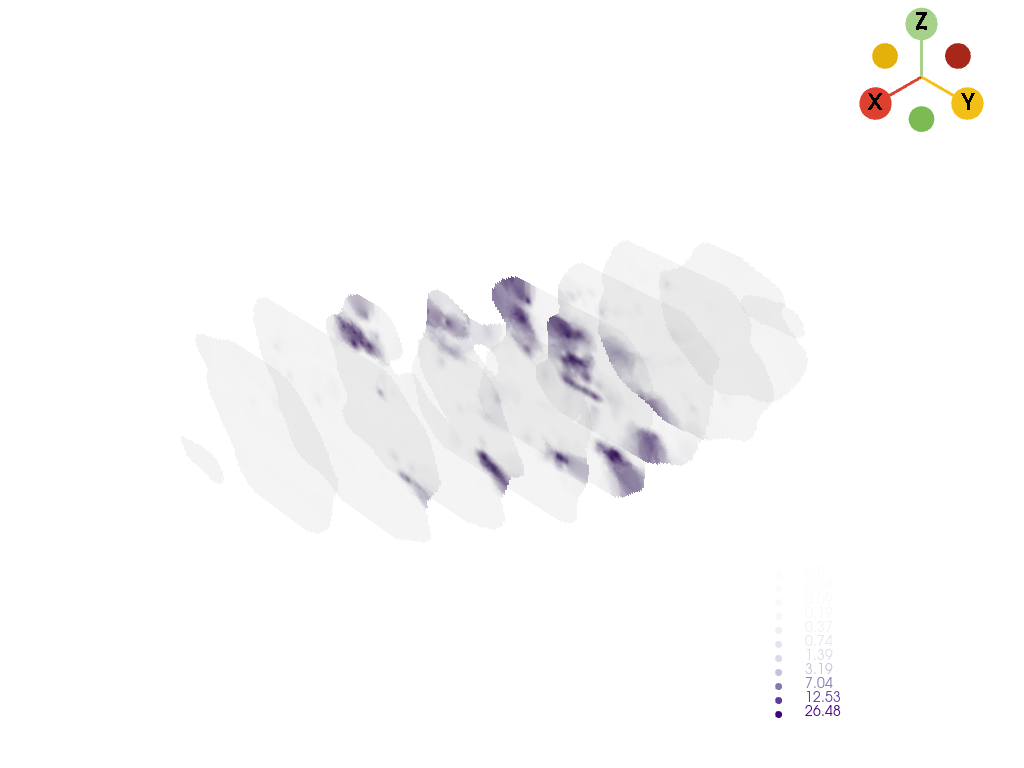

nur


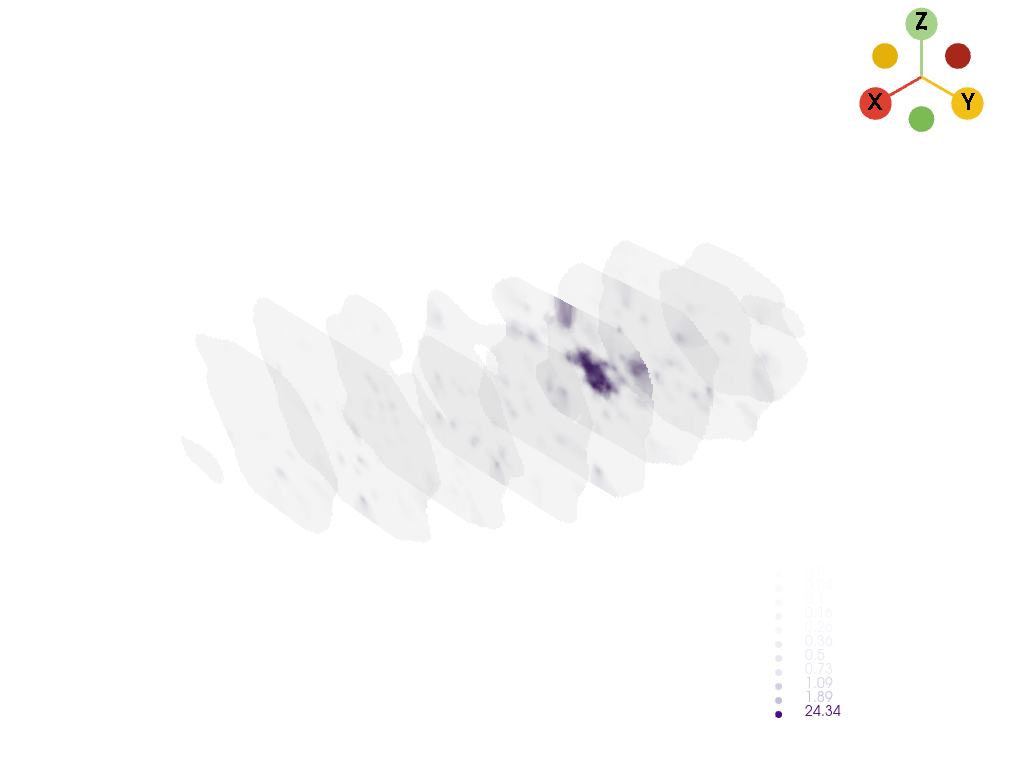

PPO1


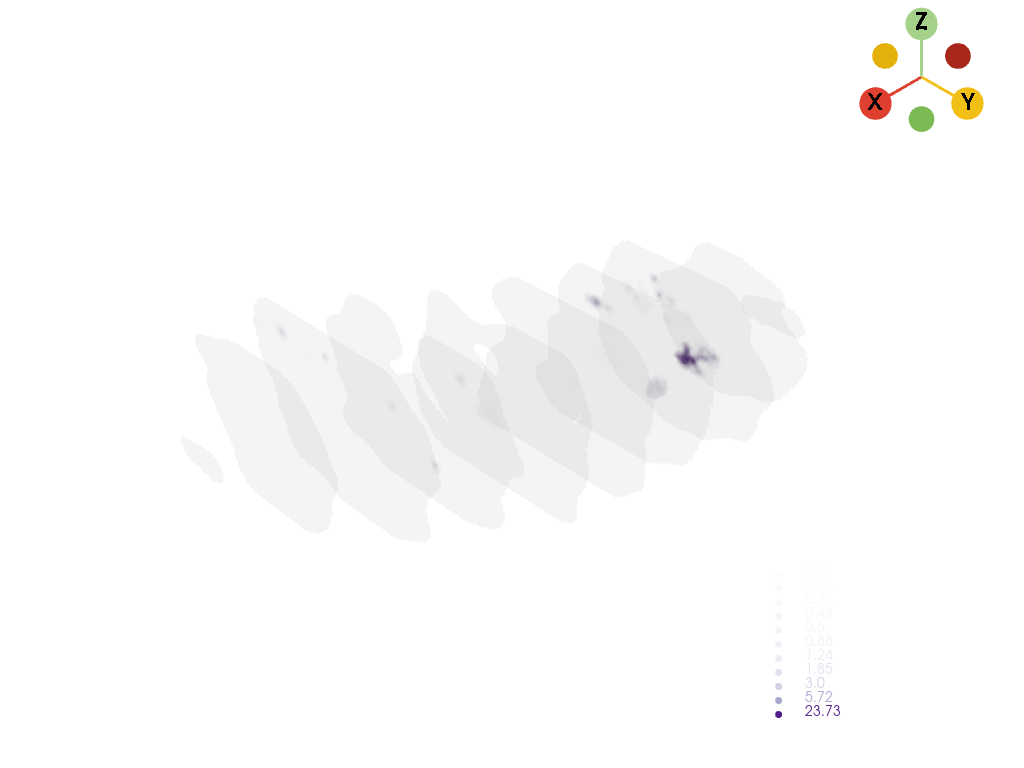

In [10]:
for gene in marker_genes:
    print(gene)
    st.pl.three_d_plot(model=slices_model, key=gene, jupyter="static", off_screen=True)
    st.pl.three_d_plot(model=slices_model, key=gene, jupyter=False, off_screen=True,
                       filename=os.path.join(save_cellbin_tdr_image_folder, f"{gene}_shepard_kernel_slicing.tiff"))

### Interpolated 3D Gene Expression Pattern in volume models based on deep learning

In [22]:
gene_name = "nur"

# take existing data point to train the model
data_dict = {"X": adata.obsm['spatial'].astype(np.float64), "Y": np.asarray(adata[:, gene_name].X).astype(np.float64)}

# Data sampler
velocity_data_sampler = st.tl.DataSampler(data=data_dict, normalize_data=False)

# set uip the deep learning model
NN_model = st.tl.DeepInterpolation(model=st.tl.interpolation_nn,
                             data_sampler=velocity_data_sampler,
                             enforce_positivity=False,
                             )

# train the deep learning model
NN_model.train(max_iter=1000,
               data_batch_size=5000,
               autoencoder_batch_size=50,
               data_lr=1e-4,
               autoencoder_lr=1e-4
               )

# predict on all voxel:
X = wb_voxel.points
V_NN = NN_model.predict(input_x=X)

# save data
import pandas as pd
pd.DataFrame(V_NN).to_csv(os.path.join(save_cellbin_tdr_mesh_folder, f"{gene_name}_deep_interpolation.csv.gz"), index=False, header=False)

RuntimeError: expected scalar type Float but found Double

In [ ]:
# add interpolation gene expression data to voxel model
interpolation_gene_exp = V_NN.values.round(4).astype(np.float32)
interpolation_gene_exp = np.asarray(interpolation_gene_exp).flatten()
st.tl.tdr.add_model_labels(model=wb_voxel, labels=interpolation_gene_exp, key_added=f"interpolation_{gene_name}", where="point_data",
                           colormap="Purples", alphamap=1.0, inplace=True)

visualization(wb_voxel, gene_name=gene_name, jupyter=True, save_image=None)
visualization(wb_voxel, gene_name=gene_name, jupyter=False,
              save_image=os.path.join(save_cellbin_tdr_image_folder, f"{gene_name}_deep_interpolation.tiff"))

### Interpolated 3D Gene Expression Pattern in volume models based on deep learning

See deep interpolate.